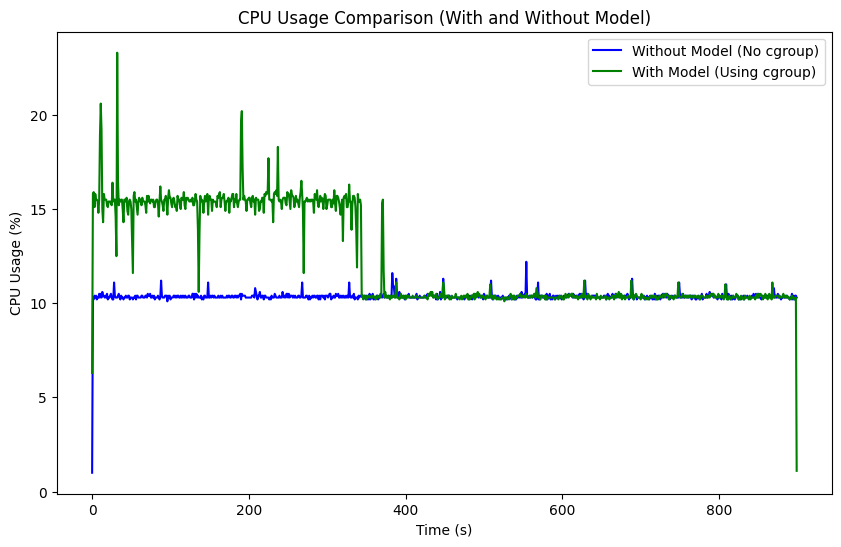

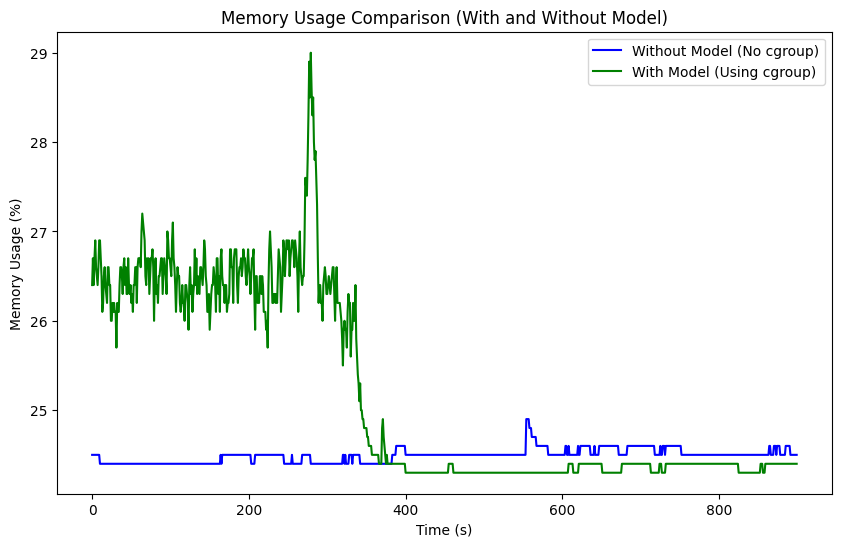

Model Evaluation: MAE = 0.10735333333333386, R2 = 0.9860760603684405
Process completed successfully.


In [2]:
import os
import subprocess
import time
import psutil
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Function to execute commands with sudo
def run_sudo_command(command):
    try:
        process = subprocess.Popen(
            ['sudo', '-S', 'bash', '-c', command],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        stdout, stderr = process.communicate(input=b'ise\n')  # Replace with your actual password
        return stdout.decode().strip()
    except Exception:
        return None

# Function to create a cgroup for CPU limitation using cgroup2
def create_cgroup(cgroup_name, cpu_limit):
    # Ensure the CPU limit is not too small
    if cpu_limit < 10000:  # 10000 microseconds = 10ms
        cpu_limit = 10000

    run_sudo_command(f"mkdir -p /sys/fs/cgroup/{cgroup_name}")
    run_sudo_command(f'echo "{cpu_limit} 100000" > /sys/fs/cgroup/{cgroup_name}/cpu.max')

# Function to add a process to the cgroup
def add_to_cgroup(cgroup_name, pid):
    if psutil.pid_exists(pid):
        try:
            run_sudo_command(f'echo {pid} > /sys/fs/cgroup/{cgroup_name}/cgroup.procs')
        except Exception:
            pass

# Function to monitor and log CPU and memory usage over time
def monitor_resources(duration=900, save_data=True, filename='system_data.csv'):
    cpu_usage = []
    memory_usage = []
    timestamps = []
    
    for second in range(duration):
        cpu_percent = psutil.cpu_percent()
        memory_percent = psutil.virtual_memory().percent
        cpu_usage.append(cpu_percent)
        memory_usage.append(memory_percent)
        timestamps.append(second)
        time.sleep(1)
    
    if save_data:
        df = pd.DataFrame({
            'Time': timestamps,
            'CPU_Usage': cpu_usage,
            'Memory_Usage': memory_usage
        })
        df.to_csv(filename, index=False)
    
    return cpu_usage, memory_usage

# Step 1: Run the 15-minute stress test to collect data
def run_stress_test(duration=900):
    stress_command = f"stress --cpu 2 --timeout {duration}"
    stress_process = subprocess.Popen(stress_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    
    time.sleep(1)
    stress_pid = stress_process.pid
    
    return stress_pid

# Step 2: Train a Random Forest model using real data
def train_random_forest(data_file='system_data.csv'):
    df = pd.read_csv(data_file)
    
    # Features: Time and Memory Usage, Target: CPU Usage
    X = df[['Time', 'Memory_Usage']].values
    y = df['CPU_Usage'].values
    
    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    return model

# Step 3: Use the trained model to predict CPU usage limit
def predict_cpu_limit(model, current_time, current_memory_usage):
    predicted_cpu_usage = model.predict([[current_time, current_memory_usage]])[0]
    return int(predicted_cpu_usage)

# Model Evaluation
def evaluate_model(model, data_file='system_data.csv'):
    df = pd.read_csv(data_file)
    X = df[['Time', 'Memory_Usage']].values
    y_true = df['CPU_Usage'].values
    
    y_pred = model.predict(X)
    
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Model Evaluation: MAE = {mae}, R2 = {r2}")
    return mae, r2

# Main function to run the entire process
def main():
    # Step 1: Collect data from a 15-minute stress test and save it
    stress_pid = run_stress_test(duration=900)
    
    # Monitor system resources for 15 minutes and save data
    cpu_usage_cgroup, memory_usage_cgroup = monitor_resources(duration=900, save_data=True)
    
    # Step 2: Train the Random Forest model using the collected data
    model = train_random_forest('system_data.csv')
    
    # Step 3: Predict the CPU limit using the trained model
    current_time = 900  # Assume this is at the end of the 15-minute test
    current_memory_usage = psutil.virtual_memory().percent
    predicted_cpu_limit = predict_cpu_limit(model, current_time, current_memory_usage)
    
    # Step 4: Create a new cgroup with the predicted CPU limit
    cgroup_name = "ml_cgroup"
    create_cgroup(cgroup_name, predicted_cpu_limit)
    
    # Step 5: Add the stress test process to the cgroup
    add_to_cgroup(cgroup_name, stress_pid)
    
    # Step 6: Run the comparison stress test without a cgroup
    no_cgroup_stress_process = subprocess.Popen("stress --cpu 2 --timeout 900", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    no_cgroup_pid = no_cgroup_stress_process.pid
    cpu_usage_no_cgroup, memory_usage_no_cgroup = monitor_resources(duration=900, save_data=False)
    
    # Step 7: Plot and compare the results (with and without the model)
    # CPU Usage Comparison Plot
    plt.figure(figsize=(10, 6))
    plt.plot(cpu_usage_no_cgroup, label="Without Model (No cgroup)", color="blue")
    plt.plot(cpu_usage_cgroup, label="With Model (Using cgroup)", color="green")
    plt.title("CPU Usage Comparison (With and Without Model)")
    plt.xlabel("Time (s)")
    plt.ylabel("CPU Usage (%)")
    plt.legend()
    plt.show()

    # Memory Usage Comparison Plot
    plt.figure(figsize=(10, 6))
    plt.plot(memory_usage_no_cgroup, label="Without Model (No cgroup)", color="blue")
    plt.plot(memory_usage_cgroup, label="With Model (Using cgroup)", color="green")
    plt.title("Memory Usage Comparison (With and Without Model)")
    plt.xlabel("Time (s)")
    plt.ylabel("Memory Usage (%)")
    plt.legend()
    plt.show()

    # Step 8: Evaluate the model
    evaluate_model(model, 'system_data.csv')

    print("Process completed successfully.")

if __name__ == "__main__":
    main()
